# Predicting Weather
**Dataset downloaded from [here](https://www.kaggle.com/datasets/ananthr1/weather-prediction?select=seattle-weather.csv)**
## Goals:
- Gain experience using multi class classification
- Build classifier to predict weather condition
- Classifier accuracy has to be over 80%
## Contents:
* [Preprocessing](#Preprocessing)
* [EDA](#EDA)
* [Model Selection and Baseline Testing](#Model-Selection-and-Baseline-Testing)
* [Parameter Tuning](#Parameter-Tuning)
* [Final Testing](#Final-Testing)

In [78]:
import pandas as pd
import numpy as np

In [79]:
df = pd.read_csv('seattle-weather.csv')

In [80]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [83]:
df.nunique()

date             1461
precipitation     111
temp_max           67
temp_min           55
wind               79
weather             5
dtype: int64

In [84]:
from sklearn.preprocessing import LabelEncoder

In [85]:
# Add encoded target label column
df['weather_encoded'] = LabelEncoder().fit_transform(df['weather'])

In [86]:
df.head(1)

,date,precipitation,temp_max,temp_min,wind,weather,weather_encoded
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle,0


### Preprocessing

In [98]:
def preprocessing(dataframe):
    # Make copy of dataset
    dataframe = dataframe.copy()
    
    # Add year and month columns to dataset
    dataframe['date'] = dataframe['date'].apply(lambda x: x.split('-'))
#     dataframe['year'] = dataframe['date'].apply(lambda x: int(x[0]))
    dataframe['month'] = dataframe['date'].apply(lambda x: int(x[1]))
    
    # Add high_precipitation column
    dataframe['high_precipitation'] = dataframe['precipitation'].apply(lambda x: 1 if x >= 1.0 else 0)
    
    # Remove date column
    dataframe = dataframe.drop(['date'], axis=1)
    
    # Re-order columns
    cols = ['precipitation', 'high_precipitation', 'temp_max', 'temp_min', 'wind', 'weather', 'month', 'weather_encoded']
    dataframe = dataframe[cols]
    
    return dataframe

In [99]:
X = preprocessing(df)

In [100]:
X.head(3)

,precipitation,high_precipitation,temp_max,temp_min,wind,weather,month,weather_encoded
0,0.0,0,12.8,5.0,4.7,drizzle,1,0
1,10.9,1,10.6,2.8,4.5,rain,1,2
2,0.8,0,11.7,7.2,2.3,rain,1,2


### EDA

In [101]:
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Removes warnings in current job (RandomizedSearch CV)
warnings.filterwarnings("ignore")
# Removes warnings in spawned jobs
os.environ['PYTHONWARNINGS']='ignore'
# Set plot size
plt.rcParams['figure.figsize'] = [15, 6]
# Set palette
sns.set_palette('pastel')

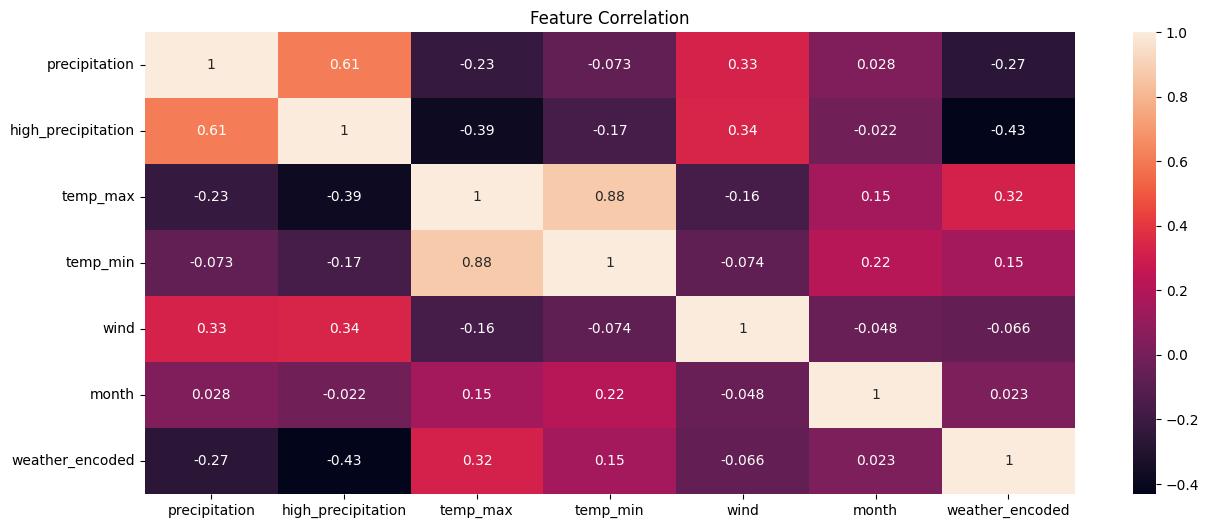

In [102]:
# Plot feature correlation
plt.title('Feature Correlation')
sns.heatmap(X.drop(['weather'], axis=1).corr(), annot=True, cmap='rocket')
plt.show()

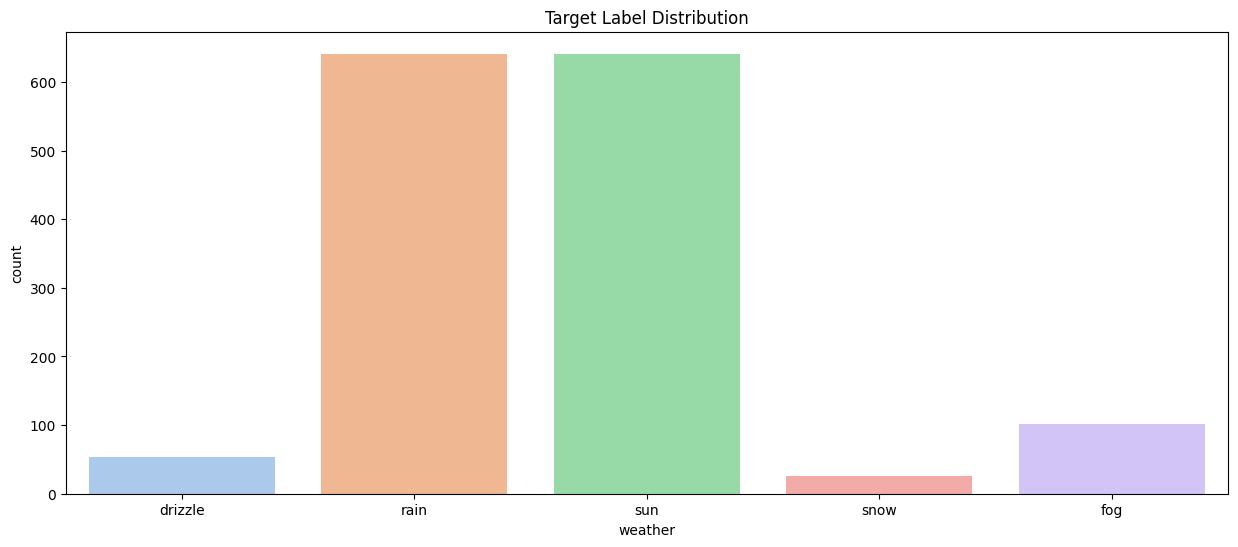

In [103]:
# Check target label distribution
plt.title('Target Label Distribution')
sns.countplot(x=X['weather'])
plt.show()

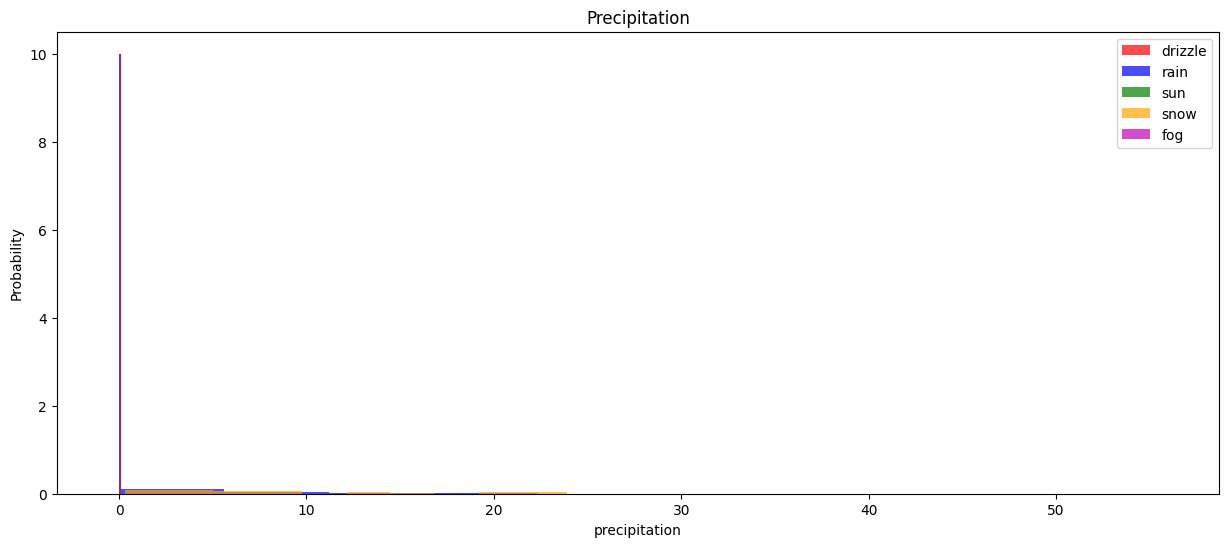

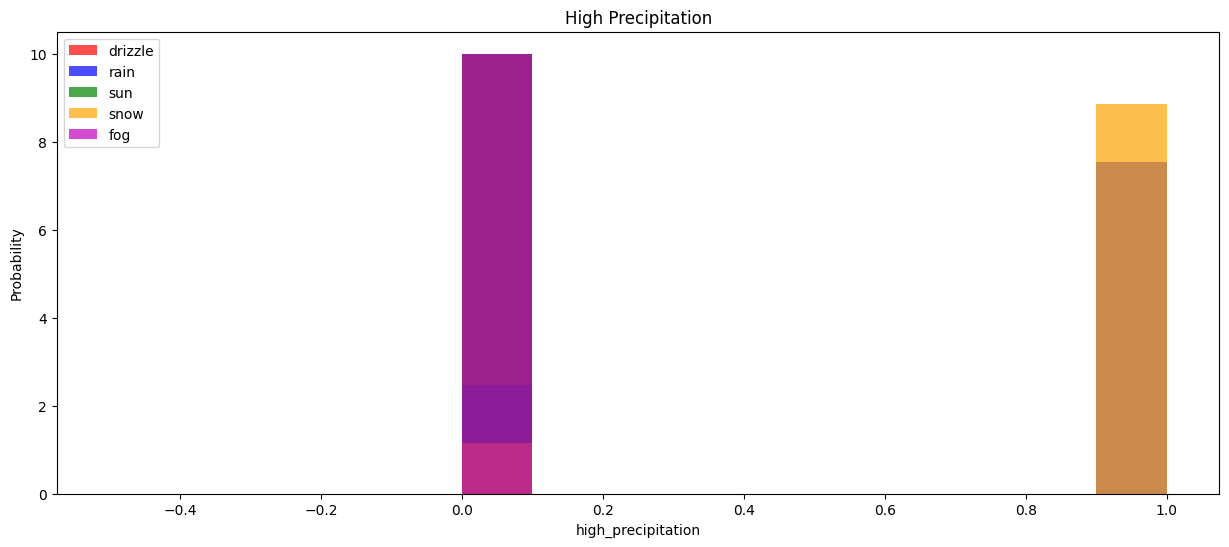

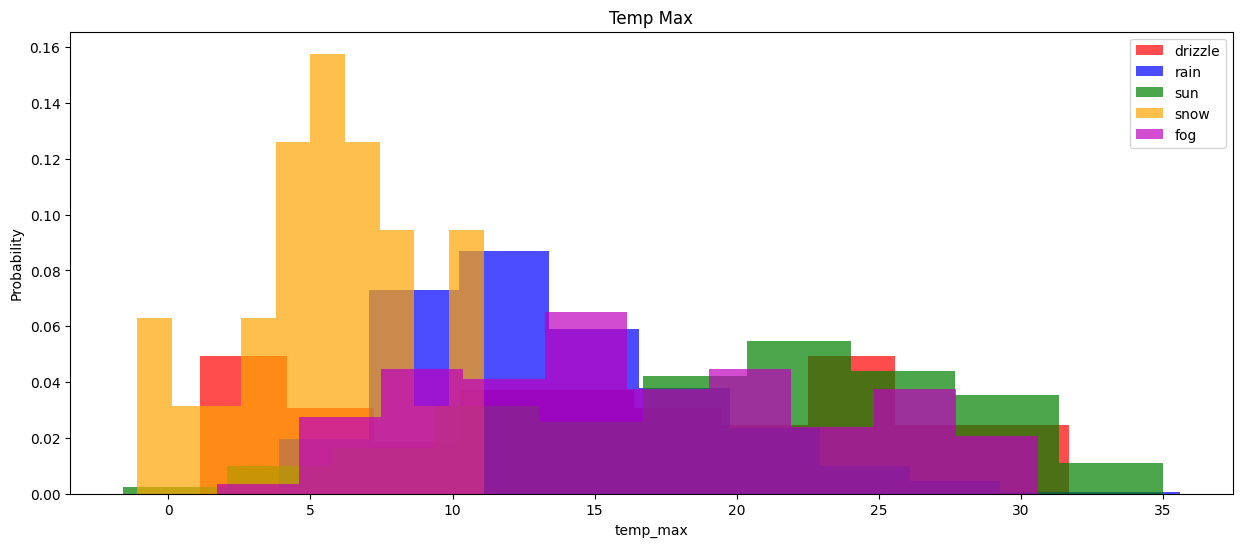

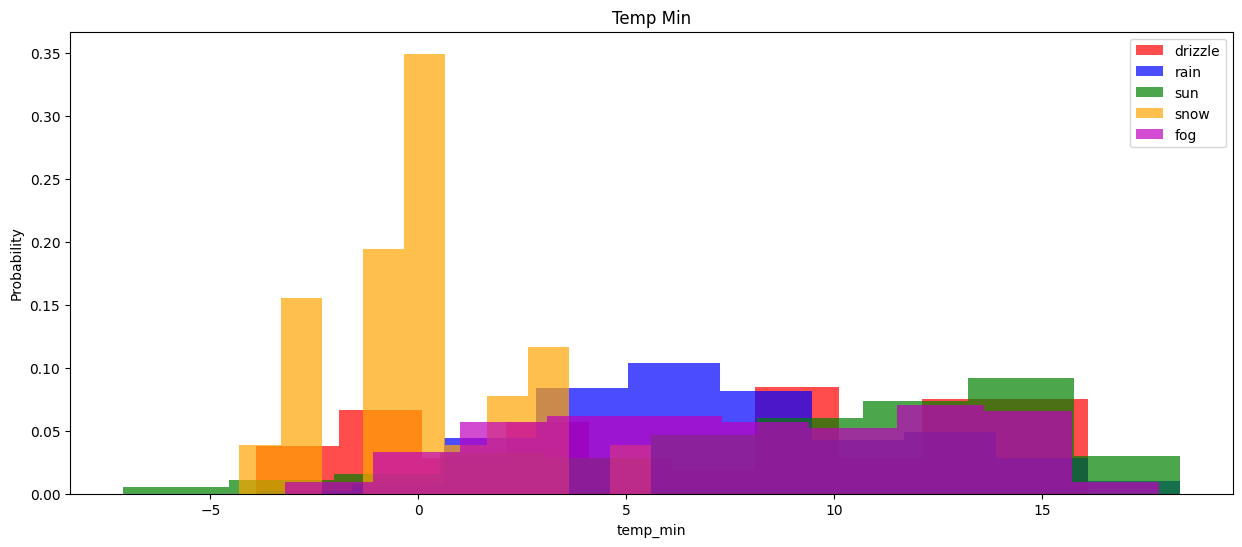

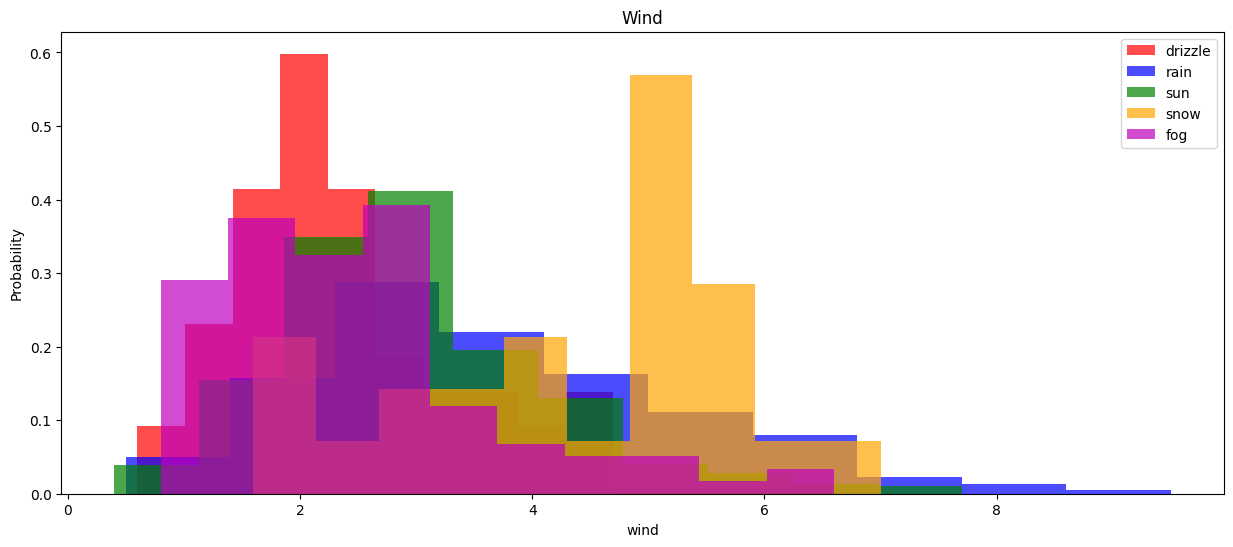

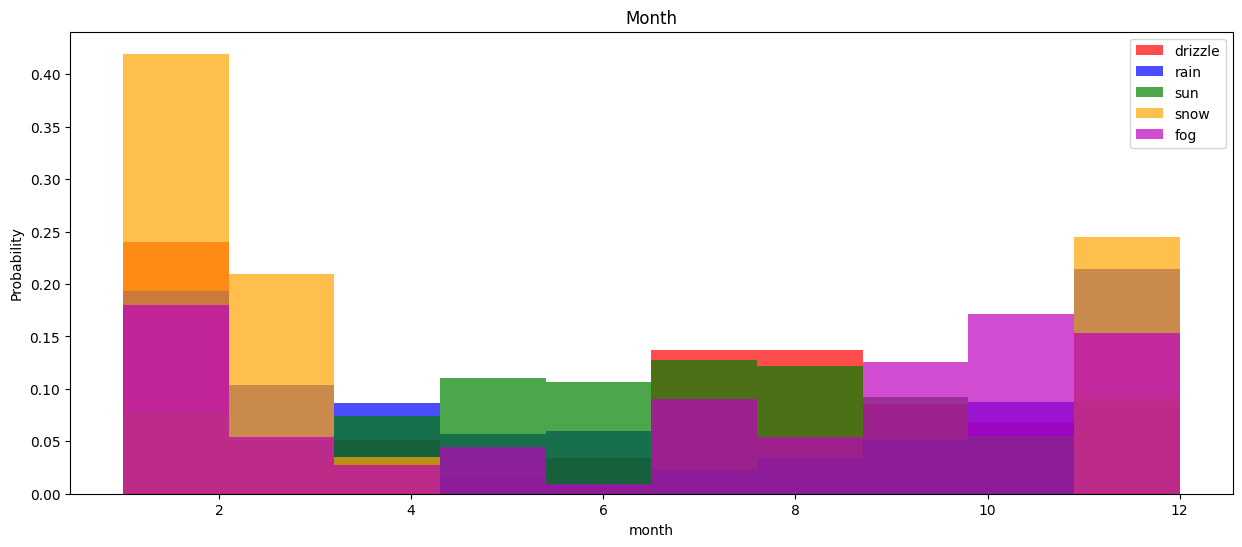

In [104]:
# Separate each target label into its own dataframe
target_dfs = [X[X['weather'] == x] for x in X['weather'].unique()]
colours = ['r', 'b', 'g', 'orange', 'm']

# Plot histograms
for feature in X.columns:
    if 'weather' in feature:
        continue
    plt.title(feature.title().replace('_', ' '))
    for index, df in enumerate(target_dfs):
        plt.hist(df[feature], density=True, label=df['weather'].unique()[0], color=colours[index], alpha=0.7)
    
    plt.xlabel(feature)
    plt.ylabel('Probability')
    plt.legend()
    plt.show()    

### Model Selection and Baseline Testing

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [106]:
X, y = X.drop(['weather', 'weather_encoded'], axis=1), X['weather_encoded']

In [107]:
# Split dataset into X_train/X_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1168, 6)
y_train shape: (1168,)
X_test shape: (293, 6)
y_test shape: (293,)


In [108]:
# Standardize X_train
s = StandardScaler()
X_train = pd.DataFrame(s.fit_transform(X_train), columns=X_train.columns)

In [109]:
X_train.head(3)

,precipitation,high_precipitation,temp_max,temp_min,wind,month
0,-0.455630,-0.734076,-1.483372,-2.293321,1.715314,1.609430
1,2.271360,1.362258,-0.345925,0.349065,2.135391,0.734420
2,2.315582,1.362258,-0.578896,-0.431640,-0.735135,-1.015602


In [110]:
# Models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [111]:
models = {
    'XGB': XGBClassifier(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoost': GradientBoostingClassifier(),
    'LogisticReg': LogisticRegression()
}

In [112]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, log_loss, roc_auc_score, confusion_matrix

MODEL: XGB
Accuracy score: 1.0
Recall score: 1.0
Precision score: 1.0
Log loss: 0.040860919227273335
ROC AUC Score: 1.0


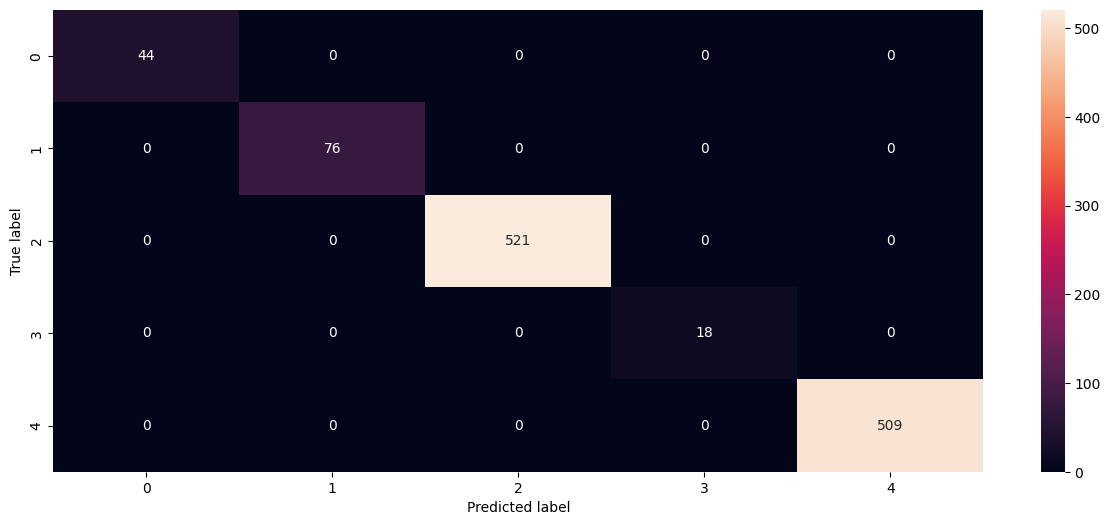

MODEL: RandomForest
Accuracy score: 1.0
Recall score: 1.0
Precision score: 1.0
Log loss: 0.09639398510126504
ROC AUC Score: 1.0


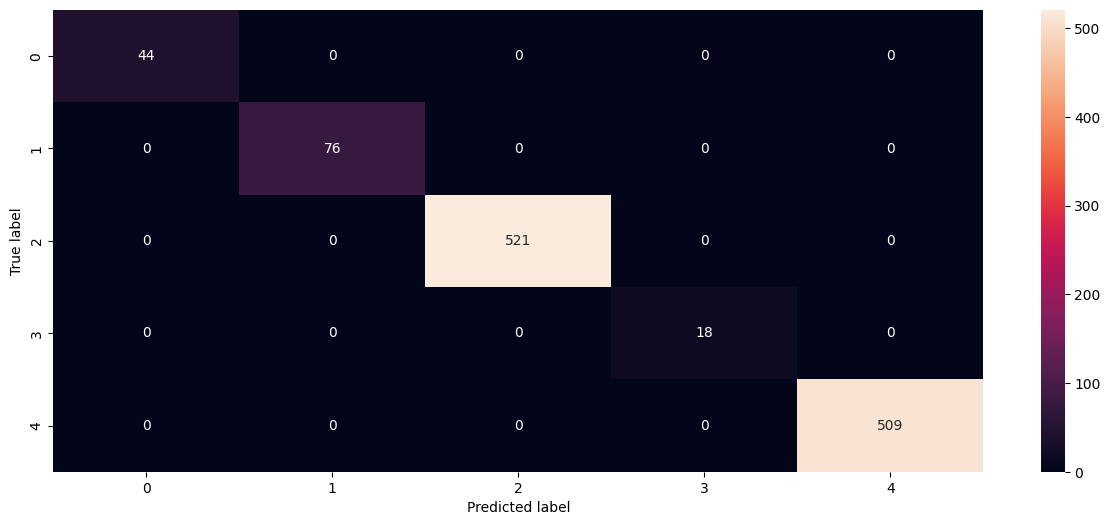

MODEL: GradientBoost
Accuracy score: 0.928082191780822
Recall score: 0.928082191780822
Precision score: 0.928082191780822
Log loss: 0.20736727136742447
ROC AUC Score: 0.9927055558100442


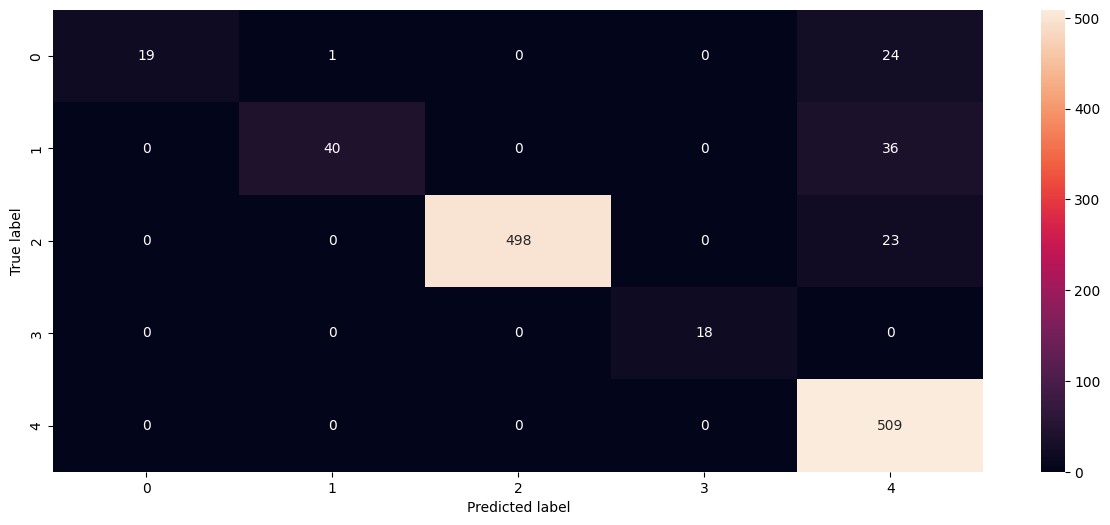

MODEL: LogisticReg
Accuracy score: 0.7833904109589042
Recall score: 0.7833904109589042
Precision score: 0.7833904109589042
Log loss: 0.5921137278724573
ROC AUC Score: 0.8694635517010985


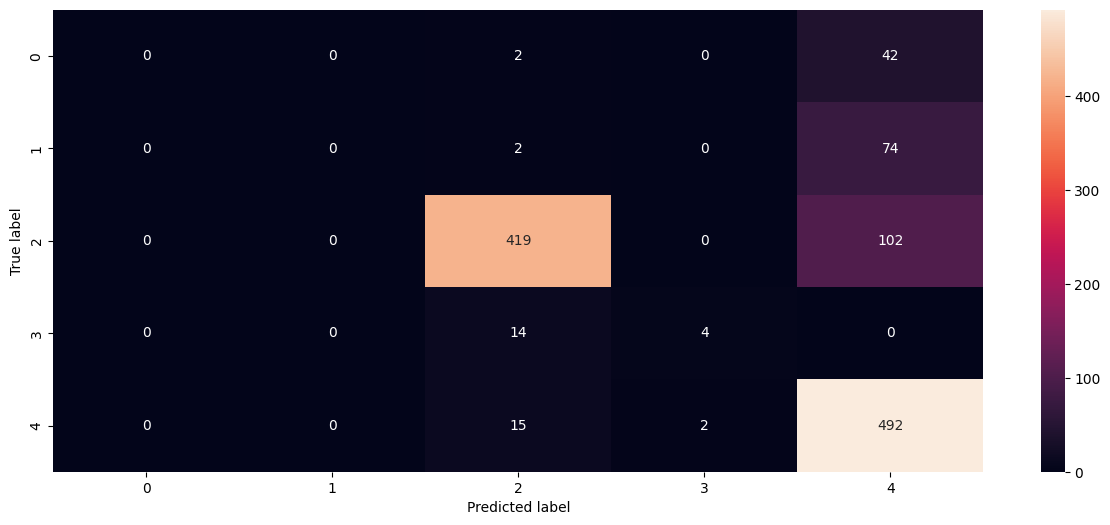

In [113]:
# Fit each model to determine baseline metrics
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    y_probas = model.predict_proba(X_train)
    
    # Display metrics
    print(f"MODEL: {name}")
    print(f"Accuracy score: {accuracy_score(y_train, y_pred)}")
    print(f"Recall score: {recall_score(y_train, y_pred, average='micro')}")
    print(f"Precision score: {precision_score(y_train, y_pred, average='micro')}")
    print(f"Log loss: {log_loss(y_train, y_probas)}")
    print(f"ROC AUC Score: {roc_auc_score(y_train, y_probas, multi_class='ovr')}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_train, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='rocket')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

### Parameter Tuning

In [114]:
from sklearn.model_selection import RandomizedSearchCV

In [115]:
model_params = {
    # XBG parameters
    'XGB': {
        'learning_rate': [0.05, 0.10, 0.15, 0.30],
        'max_depth': np.arange(1, 16, 5),
        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'colsample_bytree': [0.3, 0.4, 0.5, 0.7]
    },

    # RandomForest parameters
    'RandomForest': {
        'criterion': ['entropy', 'gini'],
        'max_depth': range(2, 21, 5),
        'max_features': ['auto', 'sqrt', 'log2'],
        'n_estimators': [90, 100, 130, 150]
    },

    # LogisticReg parameters 
    'LogisticReg': {
        'C': np.logspace(-9, 9, 30),
        'penalty': ['l2', 'l1', 'none', 'elasticnet'],
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'max_iter': [10000]
    },
    
    # GradientBooster parameters
    'GradientBoost': {
        'learning_rate': [1, 0.5, 0.01],
        'n_estimators': [1, 2, 4, 6, 100],
        'max_depth': range(5, 9),
        'max_features': list(range(1, X_train.shape[1]))
    }
}

In [116]:
fitted_models = {}

# Run RSCV on each model
for name, model in models.items():
    print(f"Fitting {name}...")
    try:
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=model_params[name],
            n_iter=60,
            cv=5,
            scoring='accuracy',
            verbose=True
        )
        
        random_search.fit(X_train, y_train)
    except Exception as e:
        print(f"ERROR with {name}: {e}")
        
    # Store best fitted estimator found during search in fitted_models 
    fitted_models[name] = {
        'model': random_search.best_estimator_,
        'params': random_search.best_params_,
        'score': random_search.best_score_,
        'cv': random_search.cv_results_
    }

print(f"\nFitting complete!")

Fitting XGB...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting RandomForest...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting GradientBoost...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting LogisticReg...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Fitting complete!


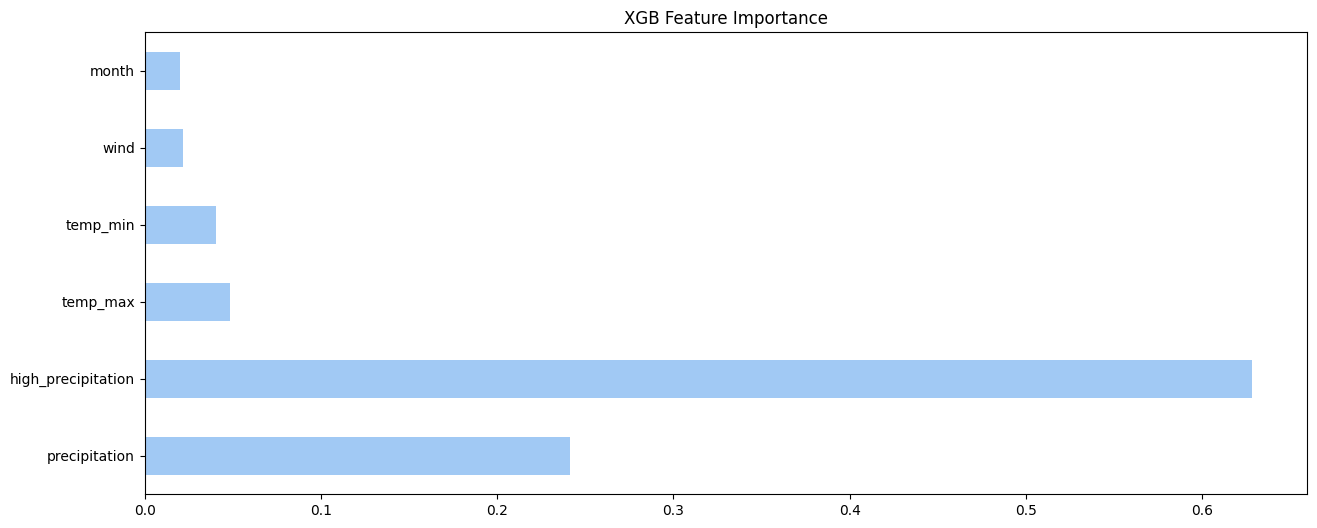

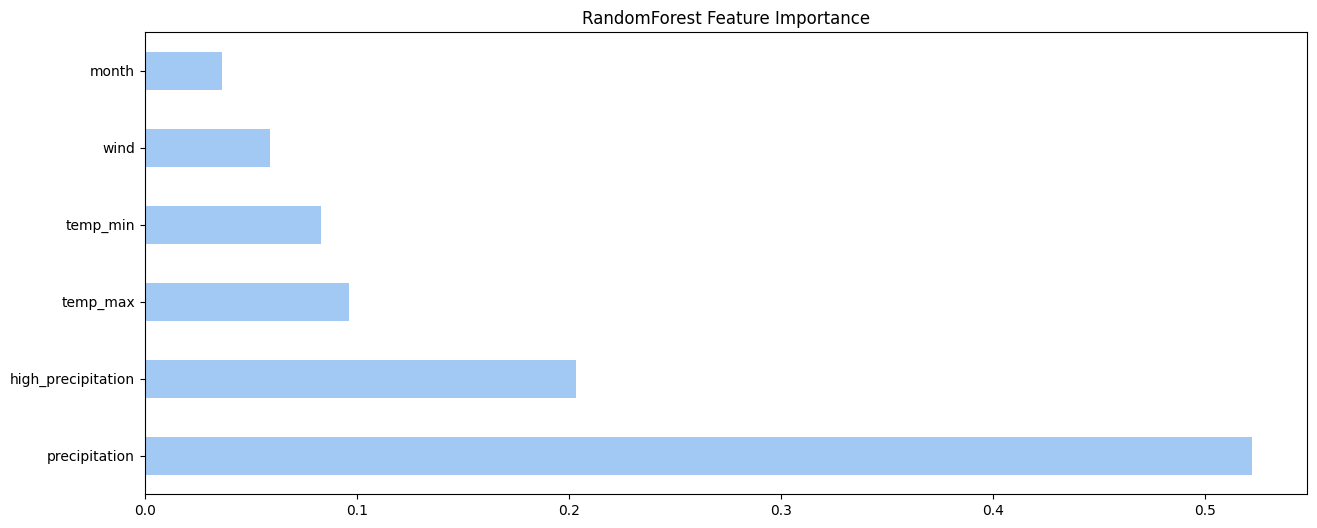

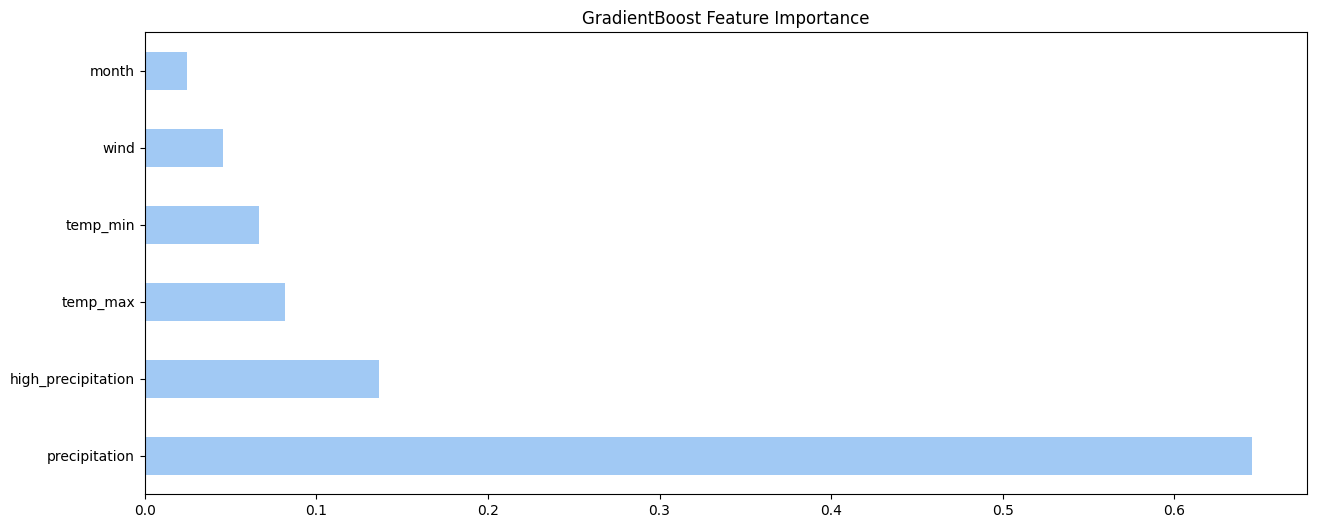

In [119]:
# Feature importance
def plot_feature_importance(importances, feature_names, model):
    pd.Series(importances, index=feature_names).plot(kind='barh')
    plt.title(f"{model} Feature Importance")
    plt.show()

for name, d in fitted_models.items():
    if name != 'LogisticReg':
        feature_names = X_train.columns
        importances = d['model'].feature_importances_
        plot_feature_importance(importances, feature_names, name)

In [120]:
for name, d in fitted_models.items():
    print(f"{name} score: {d['score']}")

XGB score: 0.8579068999669858
RandomForest score: 0.8604710025310884
GradientBoost score: 0.8579032317229742
LogisticReg score: 0.8544844283041708


### Final Testing

In [121]:
import pickle

In [122]:
def save_model(model):
    with open('model.pkl', 'wb') as f:
        pickle.dump(model, f)

def load_model(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [123]:
# Save final model
save_model(fitted_models['RandomForest']['model'])

In [124]:
# Load model
final_clf = load_model('model.pkl')
final_clf

RandomForestClassifier(max_depth=7, max_features='log2')

In [125]:
# Scale test set
final_test = pd.DataFrame(s.transform(X_test), columns=X_test.columns)

In [126]:
final_test.head(3)

,precipitation,high_precipitation,temp_max,temp_min,wind,month
0,-0.455630,-0.734076,1.024493,0.569264,-0.385071,-0.140591
1,0.399318,1.362258,-1.181880,-0.431640,-1.925353,-1.598942
2,-0.455630,-0.734076,-0.962613,-0.771947,0.105019,-1.307272


In [128]:
# Predict 
final_clf.fit(X_train, y_train)
y_pred = final_clf.predict(final_test)
y_probas = final_clf.predict_proba(final_test)

In [131]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Log loss: {log_loss(y_test, y_probas)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_probas, multi_class='ovr')}")

Accuracy: 0.8327645051194539
Log loss: 0.5017211632276378
ROC AUC: 0.9031532252903748
